# Using probability distributions to fill the gaps in our climate data
<img src="images/prob_distrib_weather.png" style="width: 400px; float:right"><h>When there are gaps in climate data—due to missing records for certain days, months, or locations—we can use probability distributions to estimate the missing information. Probability distributions are mathematical functions that describe how a particular variable, such as temperature or rainfall, is expected to vary based on past observations. By analyzing historical climate data, we can determine the likely patterns and behaviors of these variables.

For example, if we have temperature data for several years but lack information for a few specific months, we can use a probability distribution (such as the Normal distribution) to estimate the likely temperature during those missing periods. This approach relies on statistical techniques to create a model that represents how the variable typically behaves, considering factors like seasonality and trends. 
    
In this Notenbook we are going to try to fill the gaps in daily temperature and rainfall data.

## As always, first we need to import the necessary libraries

In [1]:
import numpy as np  # for numerical operations, especially with arrays
import pandas as pd  # for data manipulation and analysis
import matplotlib.pyplot as plt  # for data visualization
from scipy.stats import gamma, norm # for statistical distributions
from ipywidgets import interact, fixed, FloatSlider  # for creating interactive widgets
from tools.interactive_plots import plot_normal_fitting, plot_gamma_fitting

## Load climate data with gaps
We are going to load the data from excel files, for this purpose we use the Pandas library. The data corresponds to Montefrio (Granada, Spain) and the period 1996-2021.

<AxesSubplot:title={'center':'daily rainfall data (mm)'}, xlabel='date'>

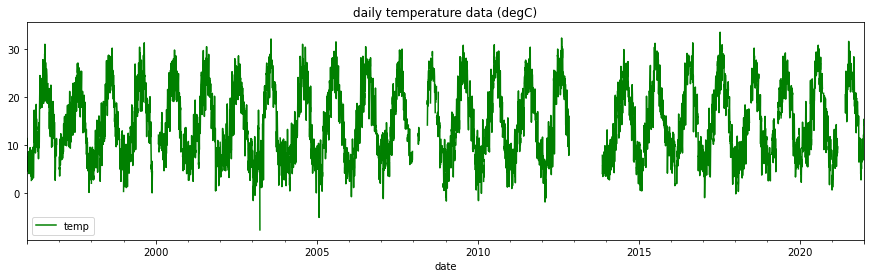

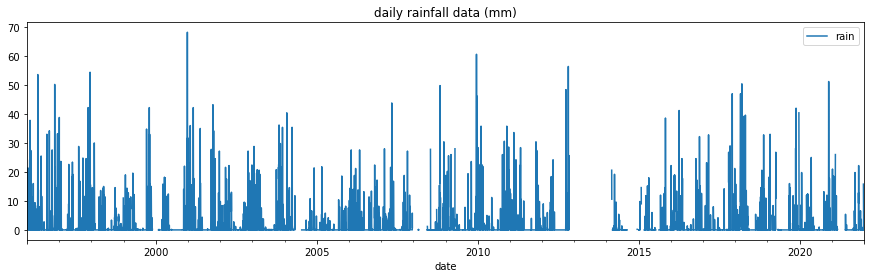

In [2]:
# Step 1: Load real temperature daily rainfall data
raw_temp_data = pd.read_excel('inputs/climate/Daily_Temp_1996_2021.xlsx',index_col=0)
raw_rain_data = pd.read_excel('inputs/climate/Daily_Rain_1996_2021.xlsx',index_col=0)

# Remove outliers (mean daily temperatures > 40 degC):
raw_temp_data['temp'][raw_temp_data['temp']>40] = np.nan

# Plot raw data
raw_temp_data.plot(figsize=[15,4], color = 'green', title = 'daily temperature data (degC)')
raw_rain_data.plot(figsize=[15,4], title = 'daily rainfall data (mm)')
#raw_rain_data['rain'].rolling(window=90).mean().plot() # plot moving average

As you can see in the figures, there are several **gaps** in the data, some of which last **several months**. **Let's try to fill these gaps using a Normal distribution.**

## Temperature: Using the normal distribution to fill the gaps in daily temperature data
<img src="images/normal_distribution.png" style="width: 400px; float:right"><h>
    
Temperature data is often symmetrically distributed around a central value, which makes the normal (Gaussian) distribution a suitable candidate. This distribution is particularly useful for modeling daily temperatures, which tend to **vary within a relatively narrow range around a seasonal average**.

The probability density function (PDF) of a normal distribution is given by:

$
f(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$

Where:
- $ x $ is the temperature,
- $ \mu $ is the mean (average temperature),
- $ \sigma $ is the standard deviation, indicating the typical variability around the mean.

### Why Normal Distribution?

1. **Symmetric values:** Temperature data typically exhibits a symmetric distribution around an average, making the normal distribution an appropriate model.
2. **Central tendency:** The normal distribution captures the tendency of temperature values to cluster around a central value, with decreasing probabilities as values move farther from the mean.
3. **Flexible variability:** With its two parameters (mean and standard deviation), the normal distribution can represent different climates and seasonal variations in temperature data, adapting to both average levels and fluctuations.

In [3]:
# Interactive function to plot the data with adjustable Normal distribution parameters
# Define interactive sliders for mean and std_dev parameters for normal distribution
mean_slider = FloatSlider(value=20, min=-10, max=40, step=1, description='Mean (°C)')
std_dev_slider = FloatSlider(value=5, min=1, max=15, step=1, description='Std Dev (°C)')

# Use `interact` to make the plot interactive
w_t = interact(plot_normal_fitting, temp_data = fixed(raw_temp_data), mean=mean_slider, std_dev=std_dev_slider)

interactive(children=(FloatSlider(value=20.0, description='Mean (°C)', max=40.0, min=-10.0, step=1.0), FloatSl…

### Questions

⚡ **What parameter values of the normal distribution give a better fit to the observed temperature data?**

⚡ **Do you think that the filling data is a good estimate of the missing temperature values? why?**

The normal distribution is often a good fit for filling gaps in daily mean temperature data, but it’s not always perfect. Daily mean temperatures tend to follow a pattern that can approximate a bell curve, especially over short time periods, like a single season. This means the normal distribution can capture the average and variability reasonably well.

Fitting a normal distribution to the entire temperature data has some limitations because real daily temperatures usually show a cycle that follows the seasons, which isn’t captured well by a single normal distribution. For example, summer temperatures tend to be warmer, and winter temperatures cooler.

We can see this limitation more clearly when we **generate a synthetic time series of daily temperature using random numbers using the fitted normal distribution, i.e. with the mean and standard deviation obtained from the observed data.**

### Generate synthetic data (1996-2021)

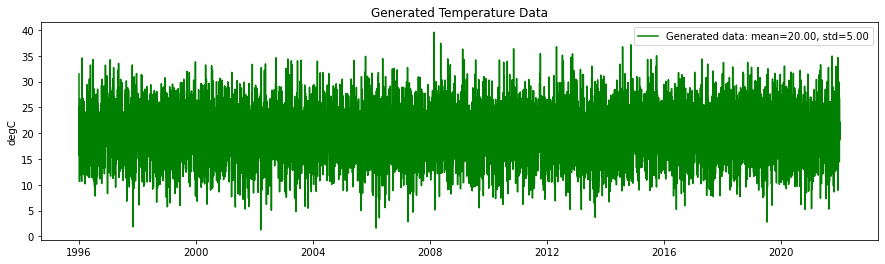

In [4]:
raw_temp_data,mean_temp,std_temp = w_t.widget.kwargs.values()
# Generate synthetic temperature data using a normal distribution
# - size = raw_temp_data.size: generates the same number of data points as in raw_temp_data
# - index = raw_temp_data.index: aligns the synthetic data's index with raw_temp_data for consistent dates
# - columns = ['temp']: names the column as 'temp'
syn_temp_data = pd.DataFrame(data=np.random.normal(loc=mean_temp, scale=std_temp, size=raw_temp_data.size), 
                             index=raw_temp_data.index, columns=['temp'])

# Plot the synthetic temperature data
plt.figure(figsize=(15, 4))  # Set the figure size to 15x4 inches
plt.plot(syn_temp_data, color='green', label=f'Generated data: mean={mean_temp:.2f}, std={std_temp:.2f}')  # Plot the synthetic temperature data
#plt.plot(raw_temp_data, color='darkgreen', label='Observed Data') 
plt.ylabel('degC')  # Label the y-axis as degrees Celsius
plt.title('Generated Temperature Data')  # Set the title of the plot
plt.legend()

### Questions

⚡ **Do you think that the generated data is a good estimate of the observed temperature values? why?**

If your goal is to capture daily mean temperatures over a relatively short period (less than a month) the normal distribution can work well. For longer periods we need to represent the temperature seasonality.

### Let's try to represent seasonal changes: we compute the mean and standard deviation for each month of the year
To represent the temperature seasonality we now compute the mean and standard deviation for each month of the year, or in other words, we fit a Normal distribution to the observed data for each month, so we will obtain 12 distributions.

Then we generate the generate temperature data for each day, based on the distribution fitted for the corresponding month.

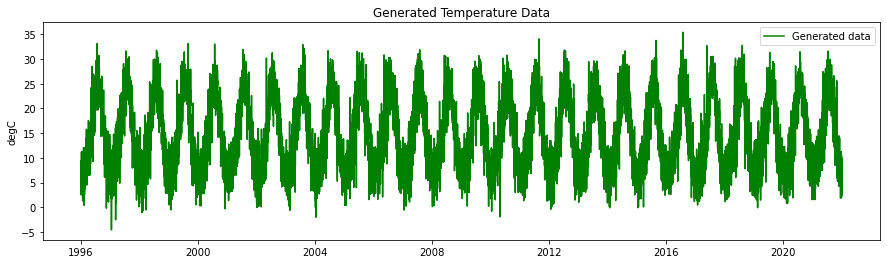

In [5]:
# Arrays to store fitted Normal distribution parameters (mean and standard deviation) for each month
fit_mean_temp, fit_std_temp = np.zeros([12,]), np.zeros([12,])

# Create a copy of the raw temperature data and remove rows with NaN values in the 'temp' column to fit the Normal distribution
fit_temp_data = pd.DataFrame.copy(raw_temp_data)
fit_temp_data.dropna(subset=["temp"], inplace=True)

# Loop over each month to fit the Normal distribution to non-missing temp data for that month
for m in np.arange(12):
    # Calculate the mean and standard deviation for each month (m+1)
    fit_mean_temp[m] = fit_temp_data[fit_temp_data.index.month == m + 1]['temp'].mean()
    fit_std_temp[m] = fit_temp_data[fit_temp_data.index.month == m + 1]['temp'].std()
    
# Create a synthetic dataset based on the Normal distribution fitted to each month
syn_temp_data = pd.DataFrame.copy(raw_temp_data)

# Generate synthetic temperature data for each day, based on the distribution fitted for the corresponding month
for i in np.arange(raw_temp_data.size):
    # Identify the month for the current day (i)
    m = raw_temp_data.iloc[[i]].index.month[0]
    
    # Generate a synthetic temperature value based on the fitted parameters for month m
    syn_temp_data['temp'][i] = norm.rvs(loc=fit_mean_temp[m - 1], scale=fit_std_temp[m - 1])

# Plot the synthetic temperature data
plt.figure(figsize=(15, 4))  # Set the figure size to 15x4 inches
plt.plot(syn_temp_data, color='green', label=f'Generated data')  # Plot the synthetic temperature data
plt.ylabel('degC')  # Label the y-axis as degrees Celsius
plt.title('Generated Temperature Data')  # Set the title of the plot
plt.legend()

### Questions

⚡ **Do you think that the new generated data is a better estimate of the observed temperature values? why?**

### Fill the gaps with the generated synthetic data
Finally, we fill the gaps in the observed data by copying the generated values that correspond to days where there are gaps.

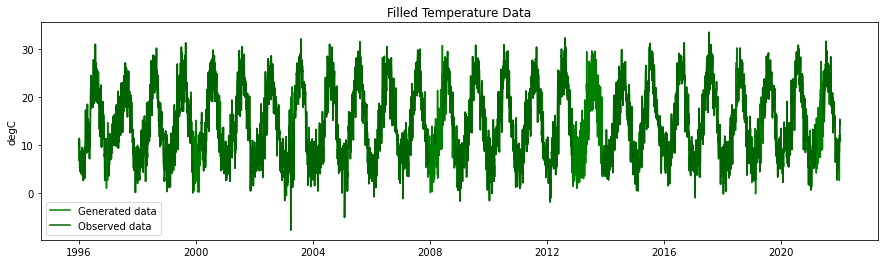

In [6]:
# Create a copy of the raw temperature data to store the final filled data
filled_temp_data = pd.DataFrame.copy(raw_temp_data)

# Fill gaps in the temperature data with values from the synthetic dataset
for i in np.arange(raw_temp_data.size):
    # Check if the current day (i) has a missing value in the original data
    if np.isnan(raw_temp_data['temp'][i]):
        # If missing, use the corresponding synthetic value for that day
        filled_temp_data['temp'][i] = syn_temp_data['temp'][i]

# Plot the observed and filled temperature data to compare
plt.figure(figsize=(15, 4))  # Set the figure size to 15x4 inches
plt.plot(filled_temp_data, color='green', label=f'Generated data')  # Plot the synthetic temperature data
plt.plot(raw_temp_data, color='darkgreen', label=f'Observed data')  # Plot the synthetic temperature data
plt.ylabel('degC')  # Label the y-axis as degrees Celsius
plt.title('Filled Temperature Data')  # Set the title of the plot
plt.legend()

## Rainfall: Using the Gamma distribution to fill the gaps in daily rainfall data
<img src="images/gamma_distribution.png" style="width: 400px; float:right"><h>
    
Rainfall is typically non-negative, skewed, and often has long tails, which makes the Gamma distribution a suitable candidate. The distribution is particularly useful for modeling the amount of rain on rainy days (i.e., positive rainfall amounts), not considering the days with no rain.

The probability density function (PDF) of a Gamma distribution is given by:

$
f(x; \alpha, \beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)} x^{\alpha-1} e^{-x/\beta}
$

Where:
- $x$ is the rainfall amount (must be positive),
- $\alpha$ is the shape parameter,
- $\beta$ is the scale parameter,
- $\Gamma(\alpha)$ is the Gamma function.

### Why Gamma Distribution?

1. **Non-negative values:** Rainfall amounts are always non-negative, and the Gamma distribution is defined only for non-negative values.
2. **Skewed data:** The distribution can capture the right-skewed nature of rainfall data, where most days have low rainfall, but there are occasional days with very high rainfall.
3. **Flexible shape:** With its two parameters (shape and scale), the Gamma distribution is quite flexible in capturing different rainfall patterns across regions and seasons.

In [11]:
# Interactive function to plot the data with adjustable Gamma distribution parameters

# Define interactive sliders for the shape, loc, and scale parameters
shape_slider = FloatSlider(value=1, min=0.01, max=0.5, step=0.01, description='Shape')
scale_slider = FloatSlider(value=10, min=1, max=20, step=1, description='Scale')

# Use `interact` to make the plot interactive
w_r = interact(plot_gamma_fitting, rain_data = fixed(raw_rain_data), alpha=shape_slider, beta=scale_slider)


interactive(children=(FloatSlider(value=0.5, description='Shape', max=0.5, min=0.01, step=0.01), FloatSlider(v…

 Values to get the best fit:
- Shape = 0.14, Scale = 5 then MSE = 0.1302, but rainfall values between 4 and 40 mm are underrepresented
- Shape = 0.12, Scale = 12 then MSE = 0.1304, but rainfall values between 5 and 40 mm are slightly underrepresented, and lower than 5 are overrepresented

Fitting a Gamma distribution to the entire rainfall data has some limitations because real daily rainfall usually show a cycle that follows the seasons, which isn’t captured well by a single Gamma distribution. For example, in summer rainfall tends to be lower.

We can see this limitation more clearly when we **generate a synthetic time series of daily rainfall using random numbers using the fitted Gamma distribution, i.e. with the mean and standard deviation obtained from the observed data.**

### Generate synthetic data (1996-2021)

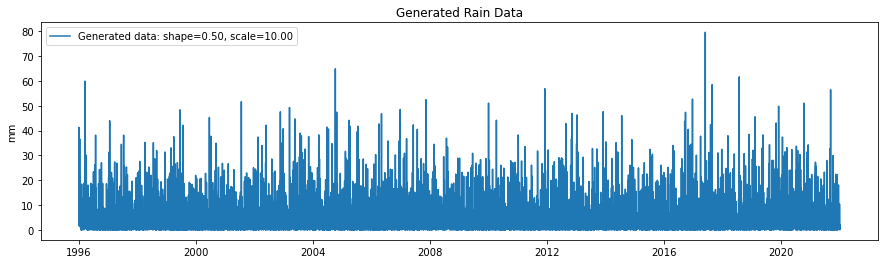

In [8]:
# Extract mean and standard deviation for rain data from widget values
raw_rain_data, shape, scale = w_r.widget.kwargs.values()

# Generate synthetic rain data using a gamma distribution
# - size = raw_rain_data.size: generates the same number of data points as in raw_rain_data
# - index = raw_rain_data.index: aligns the synthetic data's index with raw_rain_data for consistent dates
# - columns = ['rain']: names the column as 'rain'
syn_rain_data = pd.DataFrame(data=np.random.gamma(shape, scale, size=raw_rain_data.size), 
                             index=raw_rain_data.index, columns=['rain'])

# Plot the synthetic rain data
plt.figure(figsize=(15, 4))  # Set the figure size to 15x4 inches
plt.plot(syn_rain_data, label=f'Generated data: shape={shape:.2f}, scale={scale:.2f}')  # Plot the synthetic rain data
#plt.plot(raw_rain_data, color='darkblue', label='Observed Data') 
plt.ylabel('mm')  # Label the y-axis as millimeters
plt.title('Generated Rain Data')  # Set the title of the plot
plt.legend()

### Questions

⚡ **Do you think that the generated data is a good estimate of the observed daily values? why?**

If your goal is to capture daily mean rainfall over a relatively short period (less than a month) the Gamma distribution can work well. For longer periods we need to represent rainfall seasonality.

### Let's try to represent seasonal changes: we fit a Gamma distribution for each month of the year
To represent the rainfall seasonality we now compute the scale parameter and the shape parameter for each month of the year, or in other words, we fit a Gamma distribution to the observed data for each month, so we will obtain 12 distributions.

Then we generate the generate rainfall data for each day, based on the distribution fitted for the corresponding month.

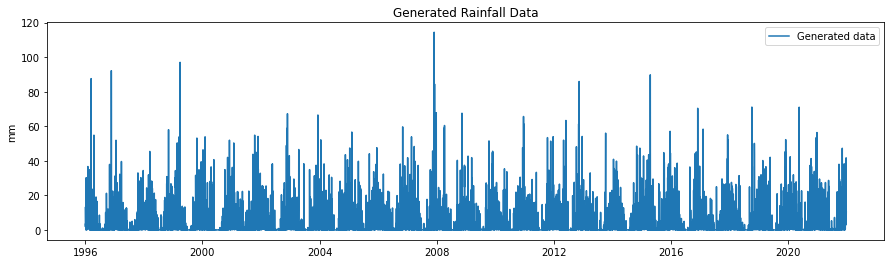

In [9]:
# Arrays to store fitted Gamma distribution parameters (shape, location, scale) for each month
fit_alpha_rain, fit_loc_rain, fit_beta_rain = np.zeros([12,]), np.zeros([12,]), np.zeros([12,])

# Create a copy of the raw rain data and remove rows with NaN values in the 'rain' column to fit the Gamma distribution
fit_rain_data = pd.DataFrame.copy(raw_rain_data)
fit_rain_data.dropna(subset=["rain"], inplace=True)

# Loop over each month to fit the Gamma distribution to non-missing rain data for that month
for m in np.arange(12):
    # Fit a Gamma distribution to the data for each month (m+1), obtaining shape (alpha), location, and scale parameters
    fit_alpha_rain[m], fit_loc_rain[m], fit_beta_rain[m] = gamma.fit(fit_rain_data[fit_rain_data.index.month == m + 1]['rain'])
    
# Create a synthetic dataset based on the Gamma distribution fitted to each month
syn_rain_data = pd.DataFrame.copy(raw_rain_data)

# Generate synthetic rain data for each day, based on the distribution fitted for the corresponding month
for i in np.arange(raw_rain_data.size):
    # Identify the month for the current day (i)
    m = raw_rain_data.iloc[[i]].index.month[0]
    
    # Generate a synthetic rain value based on the fitted parameters for month m
    syn_rain_data['rain'][i] = gamma.rvs(fit_alpha_rain[m-1], fit_loc_rain[m-1], fit_beta_rain[m-1])

# Plot the synthetic rain data
plt.figure(figsize=(15, 4))  # Set the figure size to 15x4 inches
plt.plot(syn_rain_data, label=f'Generated data')  # Plot the synthetic data
plt.ylabel('mm')  # Label the y-axis as mm
plt.title('Generated Rainfall Data')  # Set the title of the plot
plt.legend()

### Questions

⚡ **Do you think that the new generated data is a better estimate of the observed rainfall values? why?**

### Fill the gaps with the generated synthetic data
Finally, we fill the gaps in the observed data by copying the generated values that correspond to days where there are gaps.

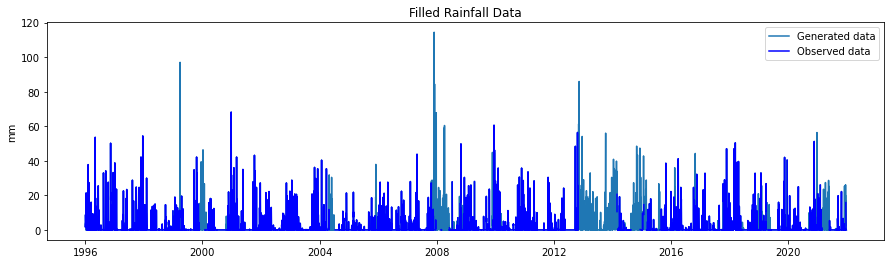

In [10]:
# Create a copy of the raw rain data to store the final filled data
filled_rain_data = pd.DataFrame.copy(raw_rain_data)

# Fill gaps in the rain data with values from the synthetic dataset
for i in np.arange(raw_rain_data.size):
    # Check if the current day (i) has a missing value in the original data
    if np.isnan(raw_rain_data['rain'][i]):
        # If missing, use the corresponding synthetic value for that day
        filled_rain_data['rain'][i] = syn_rain_data['rain'][i]

# Plot the observed and filled rain data to compare
plt.figure(figsize=(15, 4))  # Set the figure size to 15x4 inches
plt.plot(filled_rain_data, label=f'Generated data')  # Plot the synthetic data
plt.plot(raw_rain_data, color = 'blue', label=f'Observed data')  # Plot the synthetic data
plt.ylabel('mm')  # Label the y-axis as mm
plt.title('Filled Rainfall Data')  # Set the title of the plot
plt.legend()